# Aufgabe 2.3 - CartPole Umgebung

Imports:

In [1]:
import gymnasium as gym

Einfache Visualisierung mit zufällig ausgewählten

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

visualization_iterations = 1

for _ in range(visualization_iterations):
    observation, info = env.reset()
    
    episode_over = False
    
    while not episode_over:
        action = env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

env.close()

### b) - Implementierung eines intuitiven Lösungsansatzes

Imports and environment setup:

In [ ]:
import numpy as np
env = gym.make("CartPole-v1")

Config:

In [ ]:
runs = 100
num_episodes = 200

Policy 1: Wenn der Pole nach links geneigt ist, fahre nach links. Wenn der Pole nach rechts geneigt ist, fahre nach rechts.

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    total_reward = 0
    for iteration_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is leaning to the left, push the cart to the left
            if observation[2] < 0:
                action = 0
            
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        total_reward += episode_reward
        rewards[iteration_index] += (total_reward / (iteration_index + 1))

rewards_p1 = np.divide(rewards, runs)

Policy 2: Wenn der Pole nach links geneigt ist aber eine positive Winkelgeschwindigkeit hat, fahre wieder nach rechts. Analog für Neigung nach rechts.

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    total_reward = 0
    for iteration_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is leaning to the left, push the cart to the left
            falling_left = observation[3] < 0
            if falling_left:
                action = 0
            
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        total_reward += episode_reward
        rewards[iteration_index] += (total_reward / (iteration_index + 1))

rewards_p2 = np.divide(rewards, runs)

Policy 3: Zusätzliche Vermeidung des "Herausfahrens" aus der Umgebung:

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    total_reward = 0

    for iteration_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is leaning to the left, push the cart to the left
            falling_left = observation[3] < 0
            if falling_left:
                action = 0
            
            # do not drive out of the environment
            cart_position = observation[0]
            if cart_position <= -2.2:
                action = 1
            elif cart_position >= 2.2:
                action = 0

            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        total_reward += episode_reward
        rewards[iteration_index] += (total_reward / (iteration_index + 1))

rewards_p3 = np.divide(rewards, runs)

Close the environment:

In [ ]:
env.close()

Plot the reward:

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, num_episodes, num_episodes)

plt.plot(x, rewards_p1, label = 'Policy 1')
plt.plot(x, rewards_p2, label = 'Policy 2')
plt.plot(x, rewards_p3, label = 'Policy 3')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

### c) - RL-Ansatz

ObservationWrapper erstellen:

In [2]:
import numpy as np

class DiscreteObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(DiscreteObservationWrapper, self).__init__(env)
        self.cart_pos_bins = np.array([-2.4, -0.8, 0.8, 2.4])
        self.cart_vel_bins = np.array([-np.inf, -1, 1, np.inf])
        self.pole_pos_bins = np.array([-0.21, -0.05, 0.05, 0.21])
        self.pole_vel_bins = np.array([-np.inf, -0.5, 0.5, np.inf])

        self.num_states = (len(self.cart_pos_bins) - 1) * (len(self.cart_vel_bins) - 1) * (len(self.pole_pos_bins) - 1) * (len(self.pole_vel_bins) - 1)
        self.min_state_idx = self.get_state_index(1, 1, 1, 1) # we assume that the continuous state values are always within the above presented limits and thus the category can never be 0

    def get_state_index(self, cart_pos_category, cart_vel_category, pole_pos_category, pole_vel_category):
        return 27 * cart_pos_category + 9 * cart_vel_category + 3 * pole_pos_category + pole_vel_category

    def observation(self, observation):
        cart_pos, cart_vel, pole_pos, pole_vel = observation
        
        cart_pos_category = np.digitize(cart_pos, self.cart_pos_bins)
        cart_vel_category = np.digitize(cart_vel, self.cart_vel_bins)
        pole_pos_category = np.digitize(pole_pos, self.pole_pos_bins)
        pole_vel_category = np.digitize(pole_vel, self.pole_vel_bins)

        # basically binary "or" operation but in ternary system (with shifted values by 3^0 to 3^3). Ternary system is used because each category can be 1, 2 or 3
        state_index = self.get_state_index(cart_pos_category, cart_vel_category, pole_pos_category, pole_vel_category)

        return state_index

Den Banditen durch eine Klasse modellieren:

In [3]:
import numpy as np
import random

class StateBandit():
    def __init__(self, epsilon, initial_Q = 0.0):
        self.epsilon = epsilon
        self.Q = np.array([initial_Q, initial_Q])
        self.N = np.array([0, 0])
        self.G = 0.0

    def get_action(self):
        action = np.argmax(self.Q)

        # decide on exploit vs explore
        explore = random.random() <= self.epsilon
        if explore:
            action = int(random.random() >= 0.5)

        return action

    def update_metrics(self, action, reward):
        self.G += reward
        self.N[action] += 1
        self.Q[action] = self.Q[action] + 1/self.N[action] * (reward - self.Q[action])

Für jeden State einen Banditen erstellen und die Simulation laufen lassen, um die Banditen anzulernen:

In [6]:
env = gym.make('CartPole-v1')

wrapped_env = DiscreteObservationWrapper(env)

epsilon_value = 0.2
initial_Q = 0.0
bandits = [StateBandit(epsilon_value, initial_Q) for i in range(wrapped_env.num_states)]

simulation_steps = wrapped_env.num_states * 10000 # roughly 1000 iterations per state

state, info = wrapped_env.reset()
episode_over = False
for _ in range(simulation_steps):
    
    if episode_over:
        state, info = wrapped_env.reset()
        episode_over = False

    state_index = state - wrapped_env.min_state_idx
    action = bandits[state_index].get_action()
    
    state, reward, terminated, truncated, info = wrapped_env.step(action)

    bandits[state_index].update_metrics(action, reward)

    episode_over = terminated or truncated

In [7]:
for idx in range(len(bandits)):
    print(bandits[idx].N)

[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[34  2]
[0 0]
[0 0]
[13327  1445]
[0 0]
[0 0]
[213732  23527]
[181  25]
[2407  288]
[374  37]
[1006  109]
[177971  19621]
[196252  21897]
[1 0]
[3884  439]
[120355  13086]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


Testen, wie gut die Banditen sind:

In [8]:
num_episodes = 200
runs = 1

state, info = wrapped_env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    total_reward = 0

    for iteration_index in range(num_episodes):

        state, info = wrapped_env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            state_index = state - wrapped_env.min_state_idx
            action = bandits[state_index].get_action()

            state, reward, terminated, truncated, info = wrapped_env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        total_reward += episode_reward
        rewards[iteration_index] = episode_reward
        #rewards[iteration_index] += (total_reward / (iteration_index + 1))

rewards_RL = np.divide(rewards, runs)

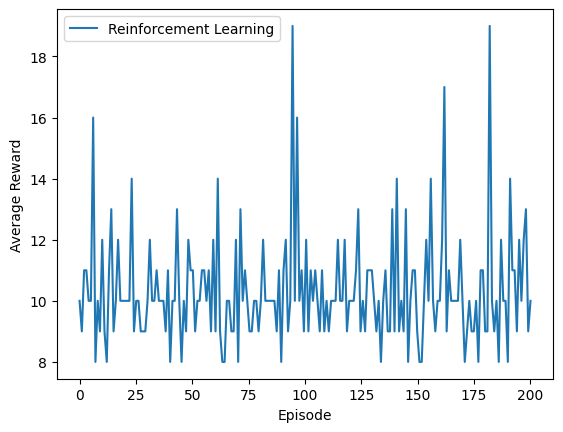

In [9]:
import matplotlib.pyplot as plt

x = np.linspace(0, num_episodes, num_episodes)

plt.plot(x, rewards_RL, label = 'Reinforcement Learning')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [ ]:
wrapped_env.close()
env.close()